In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier

start_prog = datetime.datetime(2022, 1, 1) #Дата начала периода для трехлетнего прогноза 

ter = 'Мурманская область' #Регион для которого выполняем прогноз
top_h = 5 #Количество часов для прогонза

In [2]:
# Загрузим информацию о выходных/праздничных днях
# Для дашборда файл иногда обновляется, поэтому там более менее достоверная информация
dateparser = lambda x: pd.to_datetime(x, dayfirst=True) # Считывание файла происходило сразу с парсингом даты, поэтому, чтобы избежать ошибок - указываем вручную расинг
rest_day = pd.read_excel('/mnt/Z/УБПиАЭ/ОАиП/Оперативная работа/Дашборд/Праздники+выходные.xlsx', date_parser=dateparser)
rest_day = rest_day.iloc[:, 1]
rest_day.head()

0   1999-01-01
1   1999-01-02
2   1999-01-03
3   1999-01-04
4   1999-01-07
Name: Unnamed: 1, dtype: datetime64[ns]

In [3]:
data_ml = pd.read_excel('../data/load-tree-all.xlsx', skiprows=3, sheet_name=0, header=0)
data_ml = data_ml.fillna(method='ffill', axis=0)

data_ml = data_ml.loc[:, ['Год', 'N месяца', 'N дня']+[ter]] #Оставим только требуемы регион
data_ml['data'] = pd.to_datetime(data_ml['Год'].astype(int).astype(str) + '-' +
                                 data_ml['N месяца'].astype(int).astype(str) + '-' +
                                 data_ml['N дня'].astype(int).astype(str))
data_ml.set_index('data', inplace=True)
data_ml.head()

,Год,N месяца,N дня,Мурманская область
data,,,,
2015-01-12,2015.0,1.0,12,17
2015-01-13,2015.0,1.0,13,17
2015-01-14,2015.0,1.0,14,17
2015-01-15,2015.0,1.0,15,17
2015-01-16,2015.0,1.0,16,19


In [4]:
#горизонт прогнозирования
prognoz = pd.DataFrame(index=pd.date_range(start_prog, freq='D', periods=365*3+1))
prognoz['Год'] = prognoz.index.year
prognoz['N месяца'] = prognoz.index.month
prognoz['N дня'] = prognoz.index.day

prognoz = prognoz.loc[~prognoz.index.isin(rest_day)] #Оставим только рабочие дни

data_ml = pd.concat((data_ml, prognoz), axis=0)
data_ml['number_dayofweek'] = data_ml.index.dayofweek #Добавим номер дня недели
data_ml.loc[data_ml['number_dayofweek']==5, 'number_dayofweek'] = 4 #Если рабочий день выпал на субботу (5), то заменим его номером пятницы

data_ml.head()

,Год,N месяца,N дня,Мурманская область,number_dayofweek
2015-01-12,2015.0,1.0,12,17.0,0
2015-01-13,2015.0,1.0,13,17.0,1
2015-01-14,2015.0,1.0,14,17.0,2
2015-01-15,2015.0,1.0,15,17.0,3
2015-01-16,2015.0,1.0,16,19.0,4


# Время восхода солнца  и луны

,Год,N месяца,N дня,Мурманская область,number_dayofweek,sunrise,sunset,sunrise_h,sunrise_m,sunset_h,sunset_m,Dsun,moonrise,moonset,moonrise_h,moonrise_m,moonset_h,moonset_m,Dmoon
2015-01-12,2015.0,1.0,12,17.0,0,16.166667,8.616667,8,0.616667,16,0.166667,7.550000,10.950000,0.300000,0,0.300000,10,0.950000,10.650000
2015-01-13,2015.0,1.0,13,17.0,1,16.200000,8.600000,8,0.600000,16,0.200000,7.600000,11.300000,1.433333,1,0.433333,11,0.300000,9.866667
2015-01-14,2015.0,1.0,14,17.0,2,16.216667,8.583333,8,0.583333,16,0.216667,7.633333,11.683333,2.566667,2,0.566667,11,0.683333,9.116667
2015-01-15,2015.0,1.0,15,17.0,3,16.250000,8.566667,8,0.566667,16,0.250000,7.683333,12.150000,3.716667,3,0.716667,12,0.150000,8.433333
2015-01-16,2015.0,1.0,16,19.0,4,16.283333,8.550000,8,0.550000,16,0.283333,7.733333,12.700000,4.850000,4,0.850000,12,0.700000,7.850000


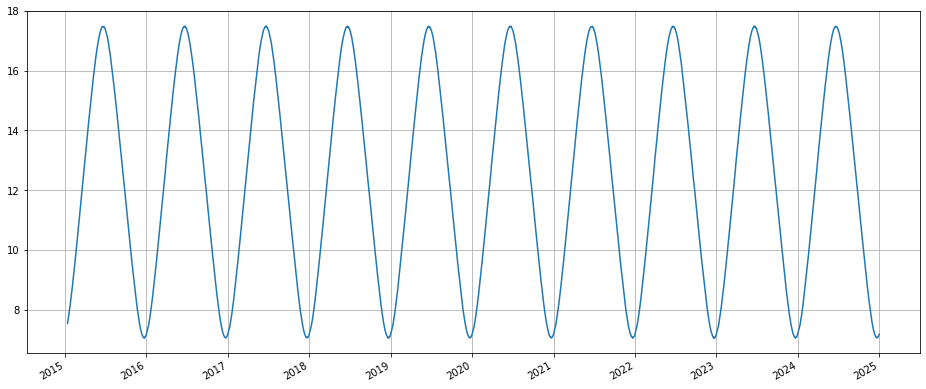

In [5]:
import ephem
sun = ephem.Sun()
moon = ephem.Moon()
raleigh = ephem.Observer()

#raleigh.lon, raleigh.lat = "68.95406", "33.08061" #мурманск
raleigh.lon, raleigh.lat = "86.10426", "55.4467" #kem
#raleigh.lon, raleigh.lat = "134.973", "48.4649" #хабар

raleigh.horizon = '-0:34'  # USNO standard atmospheric diffraction
raleigh.pressure = 0       # atmospheric refraction parameters

def riseset_obj(date, f, telo):
    raleigh.date = date
    
    if telo == 'sun':
        sun.compute(raleigh)
        sr = ephem.localtime(f(sun))    
        return sr
    elif telo == 'moon':
        moon.compute(raleigh)
        sr = ephem.localtime(f(moon))    
        return sr

def sunframe(df):
    for i in ['sun', 'moon']:
        df[f'{i}rise'] = df.index.map(lambda d: riseset_obj(d, raleigh.next_rising, i)) #+ np.timedelta64(7, 'h')
        df[f'{i}set'] = df.index.map(lambda d: riseset_obj(d, raleigh.next_setting, i)) #+ np.timedelta64(7, 'h')

        df[f'{i}rise_h'] = df[f'{i}rise'].dt.hour
        df[f'{i}rise_m'] = df[f'{i}rise'].dt.minute/60

        df[f'{i}set_h'] = df[f'{i}set'].dt.hour      
        df[f'{i}set_m'] = df[f'{i}set'].dt.minute/60

        df[f'D{i}'] = (df[f'{i}set_h'] + df[f'{i}set_m']) - (df[f'{i}rise_h'] + df[f'{i}rise_m'])
        df[f'{i}rise'] = df[f'{i}set_h'] + df[f'{i}set_m']
        df[f'{i}set'] = df[f'{i}rise_h'] + df[f'{i}rise_m']
   
    return df

data_ml = sunframe(data_ml)
data_ml['Dsun'].plot(figsize=(16,7)).grid()
display(data_ml.head())

# Дополнительные фичи

In [6]:
#Для сохранения индексации
my_index = data_ml.index

In [7]:
#Мода по номеру дня и номеру месяца
for shift_ in range(-4,5):
    moda_ml = data_ml.loc[data_ml.index<start_prog, ['N дня', 'N месяца']+[ter]]
    moda_ml = moda_ml.groupby(['N дня', 'N месяца']).agg(lambda x: x.value_counts().index[0]) #Получим самый часто встречающийся час в такой день месяца
    moda_ml = moda_ml.astype('int').shift(shift_) #Сместим моду часа вперед/назад на несколько дней
    moda_ml = moda_ml.fillna(0, axis=0).reset_index()
    moda_ml.columns = ['N дня', 'N месяца', f'moda_d_m_{shift_}'] #Переименуем столбцы с указанием типа моды
    data_ml = data_ml.merge(moda_ml, 'left', on=['N дня', 'N месяца']).set_index(my_index)
data_ml.head()

,Год,N месяца,N дня,Мурманская область,number_dayofweek,sunrise,sunset,sunrise_h,sunrise_m,sunset_h,...,Dmoon,moda_d_m_-4,moda_d_m_-3,moda_d_m_-2,moda_d_m_-1,moda_d_m_0,moda_d_m_1,moda_d_m_2,moda_d_m_3,moda_d_m_4
2015-01-12,2015.0,1.0,12,17.0,0,16.166667,8.616667,8,0.616667,16,...,10.650000,10.0,10.0,21.0,19.0,17,18.0,19.0,19.0,21.0
2015-01-13,2015.0,1.0,13,17.0,1,16.200000,8.600000,8,0.600000,16,...,9.866667,10.0,11.0,21.0,19.0,17,19.0,19.0,19.0,21.0
2015-01-14,2015.0,1.0,14,17.0,2,16.216667,8.583333,8,0.583333,16,...,9.116667,10.0,12.0,20.0,19.0,17,16.0,19.0,19.0,21.0
2015-01-15,2015.0,1.0,15,17.0,3,16.250000,8.566667,8,0.566667,16,...,8.433333,15.0,11.0,21.0,20.0,17,17.0,21.0,19.0,21.0
2015-01-16,2015.0,1.0,16,19.0,4,16.283333,8.550000,8,0.550000,16,...,7.850000,14.0,11.0,21.0,19.0,19,17.0,21.0,19.0,21.0


In [8]:
#Мода1 по дню недели и номеру месяца
for shift_ in range(-3,4):
    moda_ml = data_ml.loc[data_ml.index<start_prog, ['number_dayofweek', 'N месяца']+[ter]]
    moda_ml = moda_ml.groupby(['number_dayofweek', 'N месяца']).agg(lambda x: x.value_counts().index[0]) #Получим самый часто встречающийся час в такой день месяца
    moda_ml = moda_ml.astype('int').shift(shift_) #Сместим моду часа вперед/назад на несколько дней
    moda_ml = moda_ml.fillna(0, axis=0).reset_index()
    moda_ml.columns = ['number_dayofweek', 'N месяца', f'moda_d_w_{shift_}'] #Переименуем столбцы с указанием типа моды
    data_ml = data_ml.merge(moda_ml, 'left', on=['number_dayofweek', 'N месяца']).set_index(my_index)
data_ml.head()

,Год,N месяца,N дня,Мурманская область,number_dayofweek,sunrise,sunset,sunrise_h,sunrise_m,sunset_h,...,moda_d_m_2,moda_d_m_3,moda_d_m_4,moda_d_w_-3,moda_d_w_-2,moda_d_w_-1,moda_d_w_0,moda_d_w_1,moda_d_w_2,moda_d_w_3
2015-01-12,2015.0,1.0,12,17.0,0,16.166667,8.616667,8,0.616667,16,...,19.0,19.0,21.0,11.0,21.0,19.0,17,0.0,0.0,0.0
2015-01-13,2015.0,1.0,13,17.0,1,16.200000,8.600000,8,0.600000,16,...,19.0,19.0,21.0,11.0,21.0,19.0,19,16.0,19.0,19.0
2015-01-14,2015.0,1.0,14,17.0,2,16.216667,8.583333,8,0.583333,16,...,19.0,19.0,21.0,10.0,21.0,19.0,19,17.0,17.0,19.0
2015-01-15,2015.0,1.0,15,17.0,3,16.250000,8.566667,8,0.566667,16,...,21.0,19.0,21.0,11.0,21.0,19.0,19,16.0,19.0,19.0
2015-01-16,2015.0,1.0,16,19.0,4,16.283333,8.550000,8,0.550000,16,...,21.0,19.0,21.0,11.0,21.0,19.0,19,17.0,19.0,19.0


In [9]:
#Добавим разницу между временим заката/рассвета и модой номера дня и месяца
data_ml['sunrise_h_moda_D'] = data_ml['sunrise_h']-data_ml['moda_d_m_0']
data_ml['sunset_h_moda_D'] = data_ml['sunset_h']-data_ml['moda_d_m_0']

## Моделирование

In [10]:
cat_features = [f'moda_d_m_{i}' for i in range(-4,5)] + [f'moda_d_w_{i}' for i in range(-3,3)] + ['sunrise_h_moda_D', 'sunset_h_moda_D']
cat_features

['moda_d_m_-4',
 'moda_d_m_-3',
 'moda_d_m_-2',
 'moda_d_m_-1',
 'moda_d_m_0',
 'moda_d_m_1',
 'moda_d_m_2',
 'moda_d_m_3',
 'moda_d_m_4',
 'moda_d_w_-3',
 'moda_d_w_-2',
 'moda_d_w_-1',
 'moda_d_w_0',
 'moda_d_w_1',
 'moda_d_w_2',
 'sunrise_h_moda_D',
 'sunset_h_moda_D']

In [11]:
# Получим наборы фичей и таргетов для обучения модели и предсказания
data_ml_fact = data_ml.loc[data_ml.index<start_prog]
data_ml_prog = data_ml.loc[data_ml.index>=start_prog]

X_train, X_test, y_train, y_test = train_test_split(data_ml_fact.drop(columns=[ter]),
                                                    data_ml_fact[ter], 
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=data_ml_fact[ter])#Иногда час встречается всего 1 раз, поэтому не может быть разделен

X_prog = data_ml_prog.drop(columns=[ter])

In [12]:
#Чтобы случайно не запускался грид серч, поставим пароль
pass_t = '_'
if pass_t == 'asd029':
    cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=42)
    parameters_grid = {'depth': [2, 4, 8],
                       'iterations': [200, 600, 1000],
                       'learning_rate': [0.15, 0.1, 0.05],
                       'custom_metric': ['F1'],
                       'task_type': ['GPU'],
                       'random_seed': [42]}

    grid_cv = GridSearchCV(CatBoostClassifier(), parameters_grid, scoring='f1_weighted', cv=cv, n_jobs=2)
    grid_cv.fit(X_train,
                y_train,
                cat_features=cat_features)

    grid_cv.best_params_

In [13]:
model_cat = CatBoostClassifier(custom_metric='F1',
                               depth=8,
                               iterations=1000,
                               random_seed=42,
                               task_type='GPU')

model_cat.fit(X_train,
              y_train,
              cat_features=cat_features)

y_pred = model_cat.predict(X_test)

0:	learn: 2.5445525	total: 34.3ms	remaining: 34.3s
1:	learn: 2.5237238	total: 67.1ms	remaining: 33.5s
2:	learn: 2.4934931	total: 97.5ms	remaining: 32.4s
3:	learn: 2.4675731	total: 126ms	remaining: 31.4s
4:	learn: 2.4320523	total: 155ms	remaining: 30.8s
5:	learn: 2.4021487	total: 184ms	remaining: 30.5s
6:	learn: 2.3748106	total: 214ms	remaining: 30.3s
7:	learn: 2.3508366	total: 242ms	remaining: 30s
8:	learn: 2.3293940	total: 274ms	remaining: 30.2s
9:	learn: 2.3110824	total: 302ms	remaining: 29.9s
10:	learn: 2.2920354	total: 328ms	remaining: 29.5s
11:	learn: 2.2716110	total: 353ms	remaining: 29.1s
12:	learn: 2.2509898	total: 378ms	remaining: 28.7s
13:	learn: 2.2324158	total: 404ms	remaining: 28.4s
14:	learn: 2.2164576	total: 430ms	remaining: 28.2s
15:	learn: 2.1999852	total: 458ms	remaining: 28.2s
16:	learn: 2.1851897	total: 486ms	remaining: 28.1s
17:	learn: 2.1684167	total: 511ms	remaining: 27.9s
18:	learn: 2.1489724	total: 535ms	remaining: 27.6s
19:	learn: 2.1319577	total: 559ms	remain

In [14]:
#print(classification_report(y_test, y_pred, target_names=[i.replace('.0', '') for i in model_cat.classes_]))

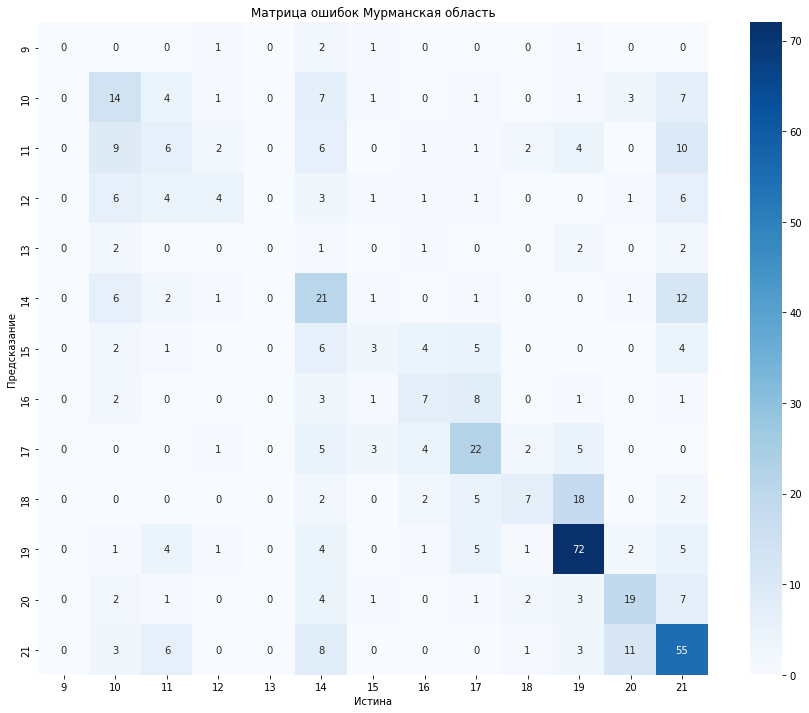

In [15]:
plt.figure(figsize=(15,12))
g = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')
g.set_xticklabels([i.replace('.0', '') for i in model_cat.classes_])
g.set_yticklabels([i.replace('.0', '') for i in model_cat.classes_])
g.set_ylabel('Предсказание')
g.set_xlabel('Истина')

bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)

plt.title('Матрица ошибок '+ter)
plt.savefig(f'../графики/{str(datetime.datetime.now())[:10]} {ter}.png', dpi=100)
plt.show()

In [16]:
#Вероятность КЧ для предсказанного часа
df_proba = pd.DataFrame(data=model_cat.predict_proba(X_prog),
                        columns=[i.replace('.0', '') for i in model_cat.classes_],
                        index=X_prog.index)*100
df_proba.head()

,9,10,11,12,13,14,15,16,17,18,19,20,21
2022-01-10,0.694883,1.907325,1.734269,0.786781,0.615184,1.028343,3.115813,3.275206,72.498909,6.740354,5.169209,1.276439,1.157285
2022-01-11,0.733129,3.330928,3.430897,1.220827,1.022475,1.296727,1.906547,3.523171,35.119224,25.215014,18.899371,2.854408,1.447282
2022-01-12,0.613227,2.447509,2.886254,1.012276,1.252008,0.936949,1.560400,3.322107,38.992154,26.242133,17.651266,1.362594,1.721124
2022-01-13,0.321735,2.082712,1.552026,1.077073,0.500772,0.662891,1.083988,4.780696,48.487613,18.742213,18.569820,0.897880,1.240581
2022-01-14,0.363418,2.455553,1.376702,0.891785,0.499485,0.724248,1.165991,4.729693,40.342150,21.708242,23.236847,1.189120,1.316765


In [17]:
#Наиболее вероятные прогнозные часы КЧ
top_prog = df_proba.apply(lambda x: x.sort_values(ascending=False).index.to_list()[:top_h], axis=1)
top_prog.head()

2022-01-10    [17, 18, 19, 16, 15]
2022-01-11    [17, 18, 19, 16, 11]
2022-01-12    [17, 18, 19, 16, 11]
2022-01-13    [17, 18, 19, 16, 10]
2022-01-14    [17, 19, 18, 16, 10]
dtype: object

In [18]:
result = pd.DataFrame(data=list(top_prog),
                      columns=['V'+str(i) for i in range(1,top_h+1)],
                      index=top_prog.index)
result.head()

,V1,V2,V3,V4,V5
2022-01-10,17,18,19,16,15
2022-01-11,17,18,19,16,11
2022-01-12,17,18,19,16,11
2022-01-13,17,18,19,16,10
2022-01-14,17,19,18,16,10


In [19]:
result.to_excel('../results/'+ter+".xlsx")